In [1]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import pipeline
import torch
import pandas as pd
import os
import re

In [2]:
# 📁 设置数据路径并读取 CSV
folder_path = '/Users/lntano/.cache/kagglehub/datasets/austinreese/trump-tweets/versions/3'
file_path = os.path.join(folder_path, 'realdonaldtrump.csv')
df = pd.read_csv(file_path)

# 👁️ 查看前几行
df.head()

,id,link,content,date,retweets,favorites,mentions,hashtags
0,1698308935,https://twitter.com/realDonaldTrump/status/169...,Be sure to tune in and watch Donald Trump on L...,2009-05-04 13:54:25,510,917,NaN,NaN
1,1701461182,https://twitter.com/realDonaldTrump/status/170...,Donald Trump will be appearing on The View tom...,2009-05-04 20:00:10,34,267,NaN,NaN
2,1737479987,https://twitter.com/realDonaldTrump/status/173...,Donald Trump reads Top Ten Financial Tips on L...,2009-05-08 08:38:08,13,19,NaN,NaN
3,1741160716,https://twitter.com/realDonaldTrump/status/174...,New Blog Post: Celebrity Apprentice Finale and...,2009-05-08 15:40:15,11,26,NaN,NaN
4,1773561338,https://twitter.com/realDonaldTrump/status/177...,"""My persona will never be that of a wallflower...",2009-05-12 09:07:28,1375,1945,NaN,NaN


In [3]:
# 🧼 文本清洗函数（可选）
def clean_text(text):
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"@\w+", "", text)
    text = re.sub(r"#\w+", "", text)
    text = re.sub(r"[^\w\s]", "", text)
    return text.strip()

df['clean_text'] = df['content'].astype(str).apply(clean_text)

In [4]:
# 🧠 情绪分析模型（Roberta for Twitter）
model_name = "cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
sentiment_pipeline = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

Device set to use mps:0


In [5]:
# 📊 标签映射
label_map = {
    "LABEL_0": "negative",
    "LABEL_1": "neutral",
    "LABEL_2": "positive"
}

In [6]:
# 🚀 情绪分析函数
def analyze_sentiment(text):
    try:
        result = sentiment_pipeline(text[:512])[0]
        return label_map[result['label']]
    except:
        return "error"

# 分析全部推文情绪
df['sentiment'] = df['clean_text'].apply(analyze_sentiment)

# 可查看前几行结果
df[['date', 'content', 'sentiment']].head()

,date,content,sentiment
0,2009-05-04 13:54:25,Be sure to tune in and watch Donald Trump on L...,positive
1,2009-05-04 20:00:10,Donald Trump will be appearing on The View tom...,neutral
2,2009-05-08 08:38:08,Donald Trump reads Top Ten Financial Tips on L...,positive
3,2009-05-08 15:40:15,New Blog Post: Celebrity Apprentice Finale and...,neutral
4,2009-05-12 09:07:28,"""My persona will never be that of a wallflower...",negative


In [7]:
# 💾 保存结果
df.to_csv("trump_sentiment_labeled.csv", index=False)
print("✅ 情感分析结果已保存到 trump_sentiment_labeled.csv")

✅ 情感分析结果已保存到 trump_sentiment_labeled.csv


<Figure size 1400x600 with 0 Axes>

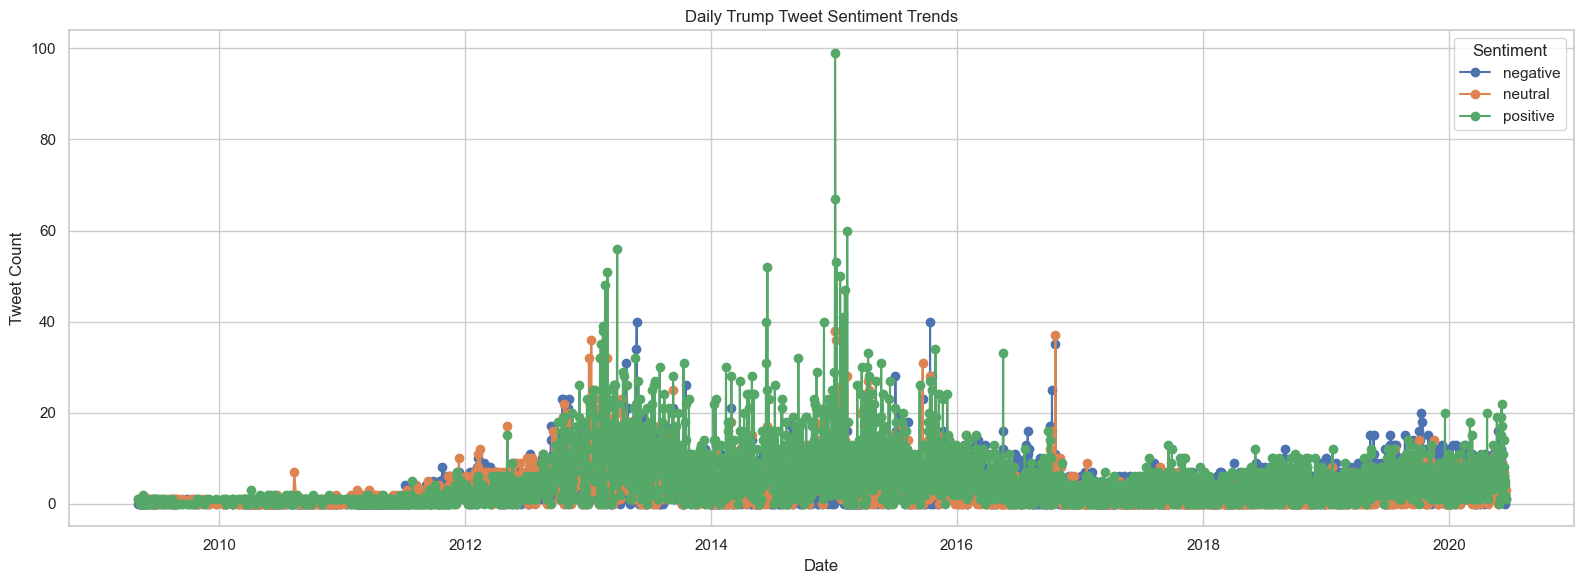

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# 📅 确保日期是 datetime 类型
df['date'] = pd.to_datetime(df['date'])
df['day'] = df['date'].dt.date  # 只保留日期，不含时间

# 📈 每天每种情绪的数量
sentiment_daily = df.groupby(['day', 'sentiment']).size().unstack(fill_value=0)

# 🎨 设置绘图风格
plt.figure(figsize=(14, 6))
sns.set(style="whitegrid")

# 📊 绘制曲线图（多条线分别表示情绪类别）
sentiment_daily.plot(kind='line', marker='o', figsize=(16, 6))
plt.title("Daily Trump Tweet Sentiment Trends")
plt.xlabel("Date")
plt.ylabel("Tweet Count")
plt.legend(title="Sentiment")
plt.tight_layout()
plt.show()

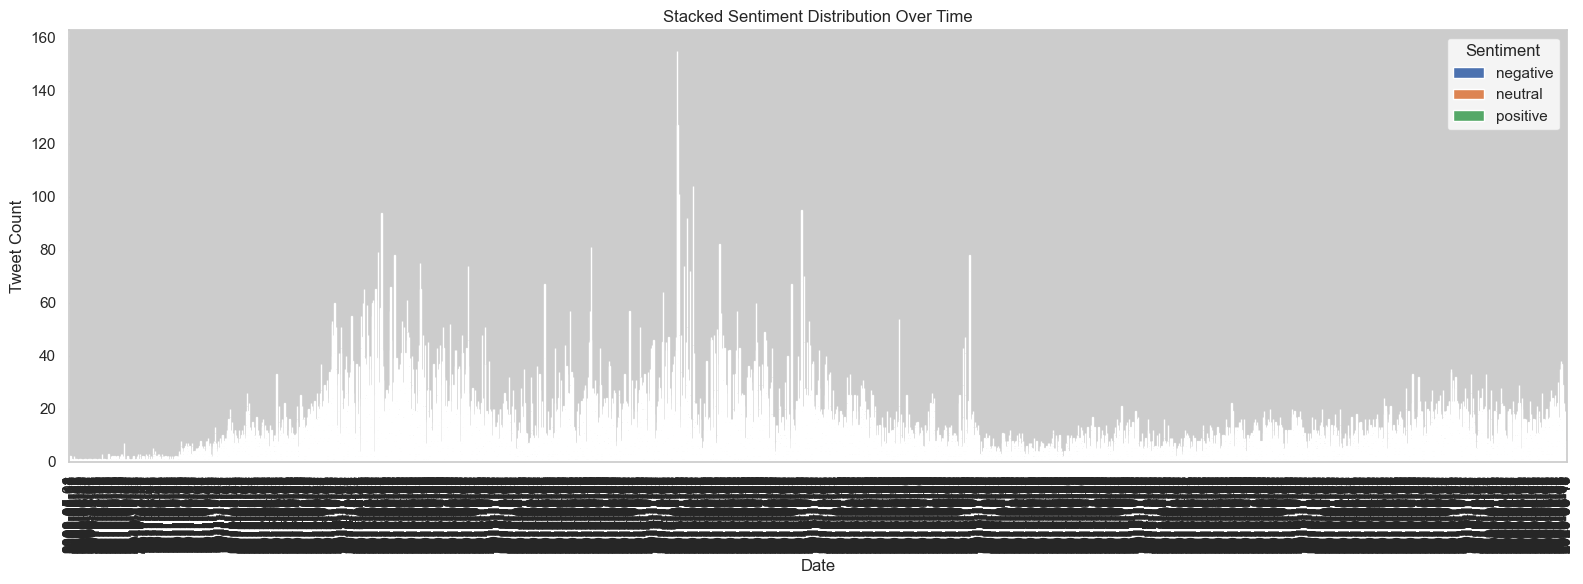

In [9]:
# 绘制展示堆叠柱状图
sentiment_daily.plot(kind='bar', stacked=True, figsize=(16, 6))
plt.title("Stacked Sentiment Distribution Over Time")
plt.xlabel("Date")
plt.ylabel("Tweet Count")
plt.legend(title="Sentiment")
plt.tight_layout()
plt.show()

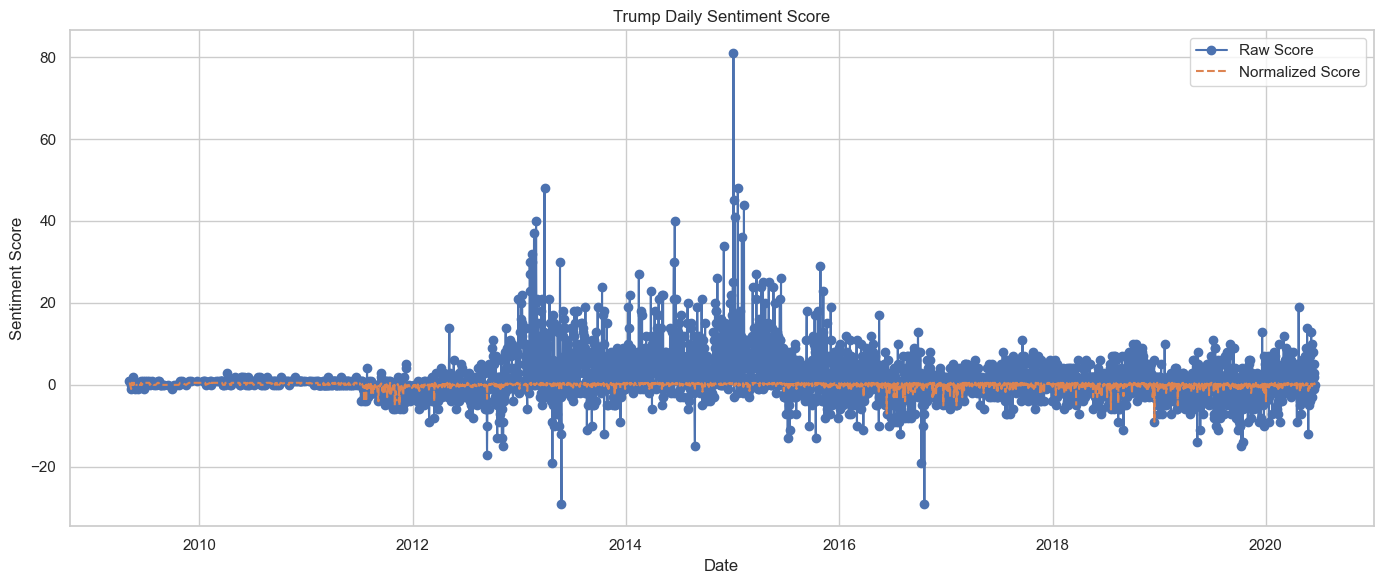

In [10]:
# 🧮 第一步：确保 date 是日期格式，并提取天
df['date'] = pd.to_datetime(df['date'])
df['day'] = df['date'].dt.date

# 🧮 第二步：计算每天每种情绪的数量
sentiment_daily = df.groupby(['day', 'sentiment']).size().unstack(fill_value=0)

# 📊 第三步：计算情绪指数
sentiment_daily['sentiment_score'] = sentiment_daily.get('positive', 0) - sentiment_daily.get('negative', 0)

# （可选）标准化版本（范围 -1 到 1）
sentiment_daily['sentiment_score_norm'] = (
    sentiment_daily.get('positive', 0) - sentiment_daily.get('negative', 0)
) / sentiment_daily.sum(axis=1)

# 🖼️ 第四步：可视化

plt.figure(figsize=(14, 6))
plt.plot(sentiment_daily.index, sentiment_daily['sentiment_score'], label='Raw Score', marker='o')
plt.plot(sentiment_daily.index, sentiment_daily['sentiment_score_norm'], label='Normalized Score', linestyle='--')
plt.title("Trump Daily Sentiment Score")
plt.xlabel("Date")
plt.ylabel("Sentiment Score")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()